In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../../module/')

import keras2
from keras2.models import Model
from keras2.layers import concatenate, Dense, Input, Flatten
from keras2.optimizers import Adam
from util import moving_average, dlqr, discretized_system, lqr
import gym2
from rl2.agents import selfDDPGAgent, selfDDPGAgent2
from rl2.memory import SequentialMemory

Using TensorFlow backend.
Using TensorFlow backend.


In [2]:
# GymのPendulum環境を作成
env = gym2.make("Pendulum-v2")

# 取りうる”打ち手”のアクション数と値の定義
nb_actios = 2
ACT_ID_TO_VALUE = {0: [-1], 1: [+1]}

In [3]:
def critic_net(a_shape , s_shape):
    action_input = Input(a_shape)
    observation_input = Input(shape=(1,)+s_shape)
    flattened_observation = Flatten()(observation_input)
    x = concatenate([action_input, flattened_observation])
    x = Dense(16, activation="relu")(x)
    x = Dense(16, activation="relu")(x)
    x = Dense(1, activation="linear")(x)
    critic = Model(inputs=[action_input, observation_input], outputs=x)
    return (critic, action_input)

def branch_actor(a_shape, s_shape):
    action_input = Input(shape=(1,)+s_shape)
    x = Flatten()(action_input) # 実質的なinput layer
    
    x1 = Dense(8, activation="relu")(x)
    x1 = Dense(8, activation="relu")(x1)
    x1 = Dense(1, activation="multiple_tanh")(x1) # action signal
    
    x2 = Dense(8, activation="relu")(x)
    x2 = Dense(8, activation="relu")(x2)
    x2 = Dense(1, activation="tau_output")(x2) # tau
    
    output = concatenate([x1, x2])
    actor = Model(inputs=action_input, outputs=output)
    return actor

# どうやって学習率を変える？

def agent2(a_shape, s_shape):
    actor = branch_actor(a_shape, s_shape)
    critic,  critic_action_input = critic_net(a_shape, s_shape)
    memory = SequentialMemory(limit = 50000, window_length = 1)
    agent = selfDDPGAgent2(
        a_shape[0],
        actor,
        critic,
        critic_action_input,
        memory,
        original_noise=True,
        clip_com = 0.01,
        batch_size = 128,
    )
    return agent

In [7]:
#safe learning   
l = 5.
step = 200000  # num of interval
episode_step = step
a = agent2((2,), (2,))
a.compile(Adam(lr=0.001, clipnorm=1.), metrics=["mae"], action_lr=0.001, tau_lr=0.0001)
a.actor.load_weights('./saved_agent/self_trigger_split_01.h5')
# a.load_weights('../learned_models_vol2/0.5standup-agent.h5')
# a.load_weights('../../learned_models_stab/lqr_optimal_agent.h5')
out = a.fit(env, l=l, nb_steps=step, visualize=0, verbose=1, nb_max_episode_steps=episode_step)

Training for 200000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 90s 9ms/step - reward: 0.1831
769 episodes - episode_reward: 2.334 [-22.124, 46.949] - loss: 0.047 - mean_absolute_error: 0.148 - mean_q: 1.210

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 95s 10ms/step - reward: 0.2553
97 episodes - episode_reward: 26.564 [-14.426, 48.858] - loss: 0.147 - mean_absolute_error: 0.179 - mean_q: 5.871

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 100s 10ms/step - reward: -0.1037
193 episodes - episode_reward: -5.267 [-27.133, 30.578] - loss: 1.352 - mean_absolute_error: 0.344 - mean_q: 12.154

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 105s 10ms/step - reward: -0.2037
100 episodes - episode_reward: -20.266 [-33.574, 0.540] - loss: 5.972 - mean_absolute_error: 0.685 - mean_q: 22.328

Interval 5 (40000 steps performed)
10000/10000 [=======

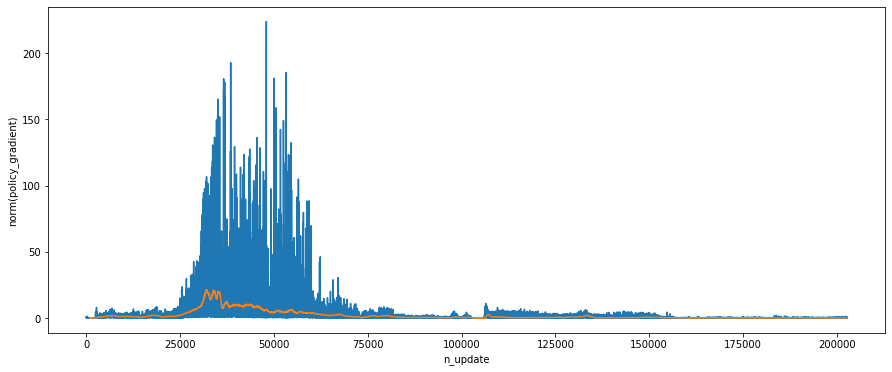

In [8]:
# gradient changing log
grads = np.array(a.gradient_log)
ma = moving_average(grads, 1000)
plt.figure(figsize=(15,6))
plt.plot(range(grads.shape[0]),grads)
plt.plot(range(1000,grads.shape[0]), ma)
plt.ylabel('norm(policy_gradient)')
plt.xlabel('n_update')
plt.show()

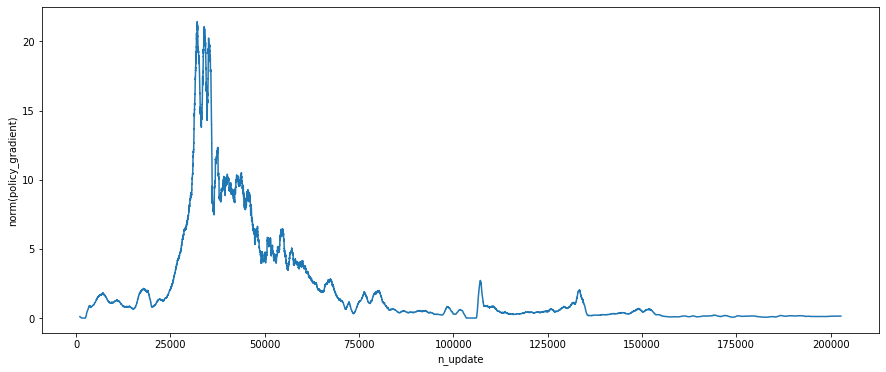

In [10]:
plt.figure(figsize=(15,6))
plt.plot(range(1000,grads.shape[0]), ma)
plt.ylabel('norm(policy_gradient)')
plt.xlabel('n_update')
plt.show()

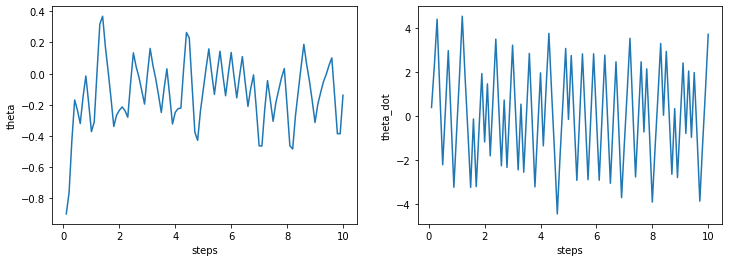

In [15]:
%matplotlib inline
def rad_clip(th):
    r = abs(th)
    while r > np.pi:
        r -= 2 * np.pi
    th = np.sign(th) * r
    return th

l = 5.
a.original_noise = False
env.reset()
env.set_state(np.array([-0.9, 0.4]))
states = []
time_limit = 10
time_log = []
taus = []
acc_time = 0
episode_reward = 0
while True:
    reward = 0
    x = env.state
    states.append([rad_clip(x[0]), x[1]])
    a_agent, tau = a.forward(x)
    taus.append(tau)
    acc_time += tau
    time_log.append(acc_time)
    action_repetition = int(np.ceil(200 * tau))  # minimum natural number which makes `dt` smaller than 0.005
    dt = tau / action_repetition
    # print(tau, dt, action_repetition)
    for p in range(action_repetition):
        _,_,r,_ = env.step(np.array([a_agent]), dt, tau)
        reward += r
    reward *= dt
    reward += - 0.01 * a_agent**2 + l * tau
    episode_reward += reward
    if acc_time > time_limit:
        break
states = np.array(states)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.xlabel('steps')
plt.ylabel('theta')
plt.plot(time_log, states[:,0])
plt.subplot(1,2,2)
plt.xlabel('steps')
plt.ylabel('theta_dot')
plt.plot(time_log, states[:,1])
plt.show()

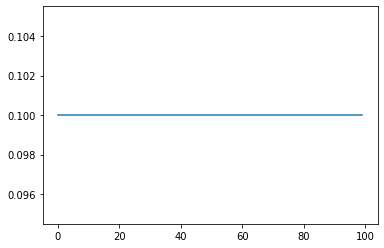

In [16]:
plt.plot(taus)

In [1]:
states = []
taus = []
high = np.array([np.pi, 8])
for _ in range(500):
    x = np.random.uniform(low=-high, high=high)
    states.append(x)
    action = a.forward(x)
    taus.append(action[1])
states = np.array(states)

NameError: name 'np' is not defined

In [ ]:
%matplotlib notebook

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)
ax.set_xlabel('theta')
ax.set_ylabel('theta_dot')
ax.set_zlabel('tau')
ax.set_zlim3d(0.001,0.1)

ax.scatter3D(states[:,0], states[:,1], taus, marker='.', alpha=0.4)

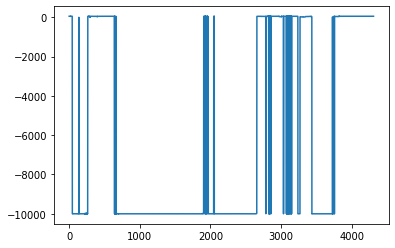

In [28]:
plt.plot(out.history['episode_reward'])

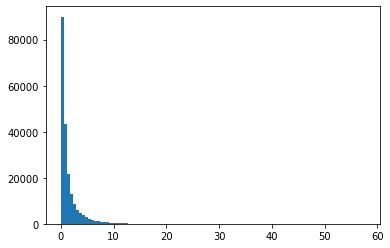

In [31]:
plt.hist(grads, bins=100)
plt.show()

In [37]:
mem = a.memory.sample(50000)
states = []
actions = []
for m in mem:
    states.append(m.state0[0])
    actions.append(m.action)
states = np.array(states)
actions = np.array(actions)

In [19]:
for i, t in enumerate(out.history['episode_average_tau']):
    print(i,t)

0 0.09643070800267264
1 0.09646976375523399
2 0.09484095080359697
3 0.09567690197918133
4 0.0955091263330374
5 0.09693069085498975
6 0.09654055128913121
7 0.09663406926862418
8 0.09619771174494501
9 0.09653400208615702
10 0.09517192839074526
11 0.09563438960247425
12 0.09670138682797112
13 0.0959365673447439
14 0.09891078797328863
15 0.09736708229892521
16 0.09917744070394963
17 0.10000000000000002
18 0.08922119329709559
19 0.1
20 0.09625018812429846
21 0.09947623133961496
22 0.09810396466202849
23 0.08853966260132763
24 0.09474341890690768
25 0.10000000000000002
26 0.10000000000000002
27 0.09860550644434156
28 0.0929488022140423
29 0.1
30 0.09781939140568825
31 0.09937762973907598
32 0.09985693450977916
33 0.09780501711729576
34 0.09369249824970122
35 0.0954917200273399
36 0.0912835626485009
37 0.09649630168921805
38 0.09648765645392132
39 0.09249707889755568
40 0.09237521142418537
41 0.09493329095106888
42 0.09734260026013068
43 0.10000000000000002
44 0.09505497290351247
45 0.0987131

931 0.09650747119664273
932 0.09502877079635474
933 0.0950544082109866
934 0.09679600461470673
935 0.0963704167501755
936 0.09474763777700769
937 0.09667813340377363
938 0.09766995958489512
939 0.0945288751763167
940 0.0968783720156169
941 0.0962790018049113
942 0.09502026090352425
943 0.09643958451537918
944 0.0968092246108499
945 0.09611443463397829
946 0.0968195260028965
947 0.0962918442711691
948 0.09470631606374001
949 0.0960750484793142
950 0.09652462727777979
951 0.09793090224268958
952 0.09580094618903079
953 0.09675493506125969
954 0.09666310803210676
955 0.09590571072405601
956 0.09450672737680595
957 0.09675283935984595
958 0.09688329030809696
959 0.09688922892094216
960 0.09593221897818265
961 0.09690108361469875
962 0.09594690959950289
963 0.0964425750118991
964 0.09556713526990902
965 0.09746189062032737
966 0.09556830784908674
967 0.09746121560668446
968 0.09697126648401402
969 0.09692483543867775
970 0.09411921509835385
971 0.0959397300227798
972 0.09611782653621914
973

1432 0.09536119387725943
1433 0.0952993775958163
1434 0.09623801642196383
1435 0.0959656932827778
1436 0.09550120432705485
1437 0.09519025810147733
1438 0.09554801441077378
1439 0.09628110908417487
1440 0.09641622370371569
1441 0.0967594584051796
1442 0.09575446204726698
1443 0.09689122396293137
1444 0.0954884152165291
1445 0.09682869863143018
1446 0.09513948446335811
1447 0.09587209669928304
1448 0.09523839257557543
1449 0.09608058808005825
1450 0.09561158054163171
1451 0.09671409152874869
1452 0.09646178389840511
1453 0.09623538773478722
1454 0.09597578874696723
1455 0.096608774219161
1456 0.09623854634327154
1457 0.0968442606766413
1458 0.09582936867054448
1459 0.09573247373665303
1460 0.09679563110779259
1461 0.09569199791141283
1462 0.09648735376620246
1463 0.09649947152363852
1464 0.09578844438354656
1465 0.09606255692747404
1466 0.0960249586257114
1467 0.0963508021535468
1468 0.0952858657082934
1469 0.09595898937247396
1470 0.09586201388842484
1471 0.0972049792014394
1472 0.0963

2182 0.09313154285115444
2183 0.09411986170115767
2184 0.10000000000000002
2185 0.10000000000000002
2186 0.09706816486771011
2187 0.10000000000000002
2188 0.09950943337382051
2189 0.10000000000000002
2190 0.09596229666253593
2191 0.09018389024143945
2192 0.09789394865461558
2193 0.10000000000000002
2194 0.09278823534496222
2195 0.09362515576691692
2196 0.10000000000000002
2197 0.09872832520225952
2198 0.09628628815391706
2199 0.10000000000000002
2200 0.09365912025000969
2201 0.09806785399267492
2202 0.09629739919353797
2203 0.09549011167001595
2204 0.09498891460440767
2205 0.0896714131798321
2206 0.0952803902585615
2207 0.10000000000000002
2208 0.09648948460533283
2209 0.09467264620867072
2210 0.09180732027349088
2211 0.0977442090741966
2212 0.09294278474897205
2213 0.0928699912797432
2214 0.0947737604784203
2215 0.09163739804362525
2216 0.08930941210922036
2217 0.09682654849058052
2218 0.0935067667829257
2219 0.09757144539734108
2220 0.09535463695756387
2221 0.09425252325353381
2222 0

2932 0.09537001194628845
2933 0.09541091797964134
2934 0.0957809121204096
2935 0.09654044994317737
2936 0.09648072202983106
2937 0.09592208476431859
2938 0.09661473441066273
2939 0.09588403520026047
2940 0.09547317423467801
2941 0.09578326330391095
2942 0.09584719688588689
2943 0.09629004076549605
2944 0.09549086525907886
2945 0.09654644692179883
2946 0.0959889769752459
2947 0.09628876490456172
2948 0.09633535237165672
2949 0.09716853114391974
2950 0.09646599641982978
2951 0.095701149310114
2952 0.09564318026569664
2953 0.0953434498419252
2954 0.09602514607420602
2955 0.09658410132660175
2956 0.09558041625837126
2957 0.09634115500981966
2958 0.09675302713200226
2959 0.0949502793466228
2960 0.09572196425180984
2961 0.09513639577890921
2962 0.09591687746189373
2963 0.09546253001181658
2964 0.09710675169773689
2965 0.09504078942801453
2966 0.09568077030984376
2967 0.09571016589711072
2968 0.09590875327347799
2969 0.09562865063308927
2970 0.09712779263111095
2971 0.09566017417172532
2972 0

3628 0.09545633210694533
3629 0.09641055114427372
3630 0.09509977924775846
3631 0.09659277342233683
3632 0.09677936646600854
3633 0.0951913961955006
3634 0.09702932748355145
3635 0.09481922951528157
3636 0.09629951976757486
3637 0.0957316121213497
3638 0.0957349403323305
3639 0.09604638786104773
3640 0.09558815196975522
3641 0.09589958968726989
3642 0.09643013688891994
3643 0.09567343991949596
3644 0.09592227289209633
3645 0.09523431821458202
3646 0.09572972635102017
3647 0.09563572973712894
3648 0.09520851448376776
3649 0.09620101434071746
3650 0.09649181498999855
3651 0.09499262856605704
3652 0.09663645859080838
3653 0.09538903843584337
3654 0.09583127228993468
3655 0.09608467743370366
3656 0.0960735461991348
3657 0.09574855467455505
3658 0.09694456763050698
3659 0.09555579857704306
3660 0.09590678056905697
3661 0.09643533054765582
3662 0.09531352663330953
3663 0.09649466805891226
3664 0.09670065831949722
3665 0.09590147986282103
3666 0.09632019477162215
3667 0.09602753427424165
3668